# Modeling

In [5]:
# !pip install git+https://github.com/openai/CLIP.git

In [32]:
# --- System and Utility ---
import os
import re
import pickle
import ast

# --- Data Handling ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Image Processing ---
import cv2
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Machine Learning: Scikit-learn ---
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

# --- Deep Learning: TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# --- Deep Learning: PyTorch and CLIP ---
import torch
import clip

# --- Model Wrapping and Caching ---
from scikeras.wrappers import KerasClassifier
from joblib import Memory

from imblearn.over_sampling import SMOTE

# Richard Load the features

PCA + t-SNE of individual features

In [14]:
hsv_df = pd.read_pickle("Features/classic_hsv_features_named.pkl")
hsv_df = pd.DataFrame(hsv_df)

features_df = hsv_df['features'].apply(pd.Series)

hsv_feature = pd.concat([hsv_df.drop(columns=['features']), features_df], axis=1)
hsv_feature['labels'] = hsv_feature['labels'].apply(lambda x: str(x[0]) if isinstance(x, (list, np.ndarray)) else str(x))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(hsv_feature['labels'])

In [16]:
encoded_labels

array([7, 2, 5, ..., 3, 5, 9])

In [42]:
# HSV Features
hsv_pca = pd.read_pickle("Features/hsv_pca.pkl")

# HOG Features
hog_pca = pd.read_pickle("Features/hog_pca.pkl")

# ResNet Features
resnet_pca = pd.read_pickle("Features/resnet_pca.pkl")

# ViT Features
vit_pca = pd.read_pickle("Features/vit_pca.pkl")

PCA + t-SNE combined features:

- HOG + HSV
- ResNet50 + HOG
- ViT + HSV
- ResNet50 + ViT (deep + deep)

In [44]:
# HOG + HSV Fetures
hsv_hog_pca = pd.read_pickle("Features/hsv_hog_pca.pkl")

# ResNet50 + HOG Features
resnet_hog_pca = pd.read_pickle("Features/resnet_pca.pkl")

# ViT + HSV Features
vit_hsv_pca = pd.read_pickle("Features/vit_hsv_pca.pkl")

# ResNet50 + ViT (deep + deep) Features 
resnet_vit_pca = pd.read_pickle("Features/resnet_vit_pca.pkl")

Baseline model

In [33]:
def plot_confusion_matrix(cm, title, labels):
    """
    Plots a confusion matrix using seaborn.

    Parameters:
      cm (ndarray): The confusion matrix.
      title (str): Plot title.
      labels (array-like): List/array of label names for the x and y axes.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.tight_layout()
    plt.show()


In [34]:
def svm_baseline(features, labels):

    X = features   
    y = labels     
    
    # Split the data with stratification to preserve the imbalanced distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    
    svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # keep enough components to retain 95% variance
    ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=42))
    ])
    
    # Train the SVM pipeline
    svm_pipeline.fit(X_train, y_train)
    
    # Predict using the SVM model
    y_pred = svm_pipeline.predict(X_test)
    return y_test, y_pred

In [35]:
def logreg_baseline(features, labels):
    X = features   
    y = labels     
    
    # Split the data with stratification to preserve the imbalanced distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('logreg', LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        class_weight='balanced', 
        random_state=42,
        max_iter=500
    ))
    ])
    
    # Train the Logistic Regression pipeline
    logreg_pipeline.fit(X_train, y_train)
    
    # Predict using Logistic Regression model
    return logreg_pipeline.predict(X_test)

In [36]:
def model_report(y_test, y_pred, classifier="SVM", features="ResNet50 + HOG"):
    
    print(f"=== {classifier} Classification Report for {features} features ===")
    print(classification_report(y_test, y_pred))
    
    print(f"=== {classifier} Confusion Matrix for {features} features ===")
    print(confusion_matrix(y_test, y_pred))

In [37]:
hog_df.labels.value_counts()

labels
Drama                   10803
Comedy/Romance           4920
Historical/Biography     3371
Suspense                 2533
Action/Adventure         2334
Music/Musical            1747
War/Crime                1371
Sport/News                836
Sci-Fi/Fantasy            730
Western/Family            620
Name: count, dtype: int64

In [39]:
# ==========  ResNet50 + HOG ========== #
# y_test_hsv, hsv_y_pres_svm = svm_baseline(resnet_hog_features, encoded_labels)

In [40]:
# model_report(y_test_hsv, hsv_y_pres_svm, classifier="SVM", features="ResNet50 + HOG")

In [41]:
# hsv_y_pres_logres = logreg_baseline(resnet_hog_features, encoded_labels)

In [42]:
# model_report(y_test_hsv, hsv_y_pres_logres, classifier="Logistic Regression", features="ResNet50 + HOG")

**Models: SVM**

In [38]:
# Prepare the different feature combinations.
features_dict = {
    "HSV": hsv_pca,
    "HOG": hog_pca,
    "ResNet50": resnet_pca,
    "ViT": vit_pca,
    "HOG+HSV": hsv_hog_pca,
    "ResNet50+HOG": resnet_hog_pca,
    "ViT+HSV": vit_hsv_pca,
    "ResNet50+ViT": resnet_vit_pca
}

In [45]:
# # Variables to track the best performing model
# best_model = None
# best_score = -np.inf
# best_combination = None
# best_cv_score = -np.inf
# best_params = None

# # To record results for all combinations
# results = []

In [46]:
# # Hyperparameter grid for SVC: two grids for linear and RBF kernels.
# param_grid = [
#     {'svm__kernel': ['linear'], 'svm__C': [0.1, 1, 10, 100]},
#     {'svm__kernel': ['rbf'],    'svm__C': [0.1, 1, 10], 'svm__gamma': [1e-3, 1e-4]}
# ]

In [47]:
# # Stratified 5-fold for GridSearchCV
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [48]:
# # Loop over each feature combination:
# for combo_name, X_features in features_dict.items():
#     print(f"\nProcessing feature combination: {combo_name}")
    
#     # Set X to the current combination and y to labels
#     X = X_features
#     y = encoded_labels
    
#     # Split the data with stratification (80% train, 20% validation)
#     X_train, X_val, y_train, y_val = train_test_split(
#         X, y, stratify=y, test_size=0.2, random_state=42)

#     memory = Memory(location='./cache', verbose=0)
    
#     # Build a pipeline: scaling, PCA (retain 95% variance), then SVM.
#     pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('pca', PCA(n_components=0.95)),  # can also be an int if you wish
#         ('svm', SVC(class_weight='balanced', random_state=42))
#     ], memory=memory)
    
#     # Perform GridSearchCV to tune the SVM parameters
#     grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
#     grid_search.fit(X_train, y_train)
    
#     # Get best cross-validation score and best parameters for the current combination
#     current_cv_score = grid_search.best_score_
#     print(f"  Best CV Score: {current_cv_score:.4f}")
#     print(f"  Best Parameters: {grid_search.best_params_}")
    
#     # Evaluate the best estimator on the validation set
#     val_score = grid_search.score(X_val, y_val)
#     print(f"  Validation Score: {val_score:.4f}")
    
#     # Record results
#     results.append({
#         'combination': combo_name,
#         'best_cv_score': current_cv_score,
#         'validation_score': val_score,
#         'best_params': grid_search.best_params_,
#         'best_estimator': grid_search.best_estimator_
#     })
    
#     # Update the best model if this combination performed best on validation
#     if val_score > best_score:
#         best_score = val_score
#         best_cv_score = current_cv_score
#         best_combination = combo_name
#         best_model = grid_search.best_estimator_
#         best_params = grid_search.best_params_




In [49]:
# # Print a summary of results for all combinations
# print("\n===== Summary of Feature Combination Results =====")
# for r in results:
#     print(f"Combination: {r['combination']:15s} | Best CV Score: {r['best_cv_score']:.4f} | "
#           f"Validation Score: {r['validation_score']:.4f} | Params: {r['best_params']}")
    
# print("\n===== Best SVM Model Overall =====")
# print(f"Best Combination: {best_combination}")
# print(f"Validation Score: {best_score:.4f}")
# print(f"Best CV Score: {best_cv_score:.4f}")
# print(f"Best Parameters: {best_params}")

# # Save the best model and its details to a pickle file.
# best_model_details = {
#     'combination': best_combination,
#     'best_cv_score': best_cv_score,
#     'validation_score': best_score,
#     'best_params': best_params,
#     'best_estimator': best_model
# }

In [50]:
# with open("best_svm_model.pkl", "wb") as f:
#     pickle.dump(best_model_details, f)

# print("\nBest SVM model details saved to 'best_svm_model.pkl'")

In [51]:
# # Open the pickle file in read-binary mode
# with open("Features/best_svm_model.pkl", "rb") as f:
#     best_model_details_svm = pickle.load(f)

# # Extract the best estimator from the loaded dictionary
# best_model_svm = best_model_details['best_estimator']

# # (Optional) Print some details about the loaded model
# print("Loaded model based on feature combination:", best_model_details_svm['combination'])
# print("Validation Score:", best_model_details_svm['validation_score'])

# **RICHARD RUN THIS:**
**Models: Logistic Regression**

In [24]:
# Variables to track the best performing logistic regression model
best_model = None
best_score = -np.inf
best_combination = None
best_cv_score = -np.inf
best_params = None

# List to record results from all feature combinations
results = []

In [26]:
# Define hyperparameter grid for Logistic Regression.
# We tune the inverse regularization parameter "C". (Higher C means lower regularization.)
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

# Use a stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [46]:
# Iterate over each feature combination
for combo_name, X_features in features_dict.items():
    print(f"\nProcessing feature combination: {combo_name}")
    
    # Use current feature matrix (X) and common labels (y)
    X = X_features
    y = encoded_labels
    
    # Split the data into training and validation sets (80/20 split) using stratification
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    
    # Build the pipeline: scaling -> PCA -> Logistic Regression
    # LogisticRegression is set to use multinomial loss, lbfgs solver, and balanced class weights.
    pipeline = Pipeline([
        # ('scaler', StandardScaler()),
        # ('pca', PCA(n_components=0.95)),
        ('logreg', LogisticRegression(
            multi_class='multinomial', 
            solver='lbfgs', 
            class_weight='balanced', 
            random_state=42, 
            max_iter=500
        ))
    ])
    
    # Set up GridSearchCV on the pipeline using the defined hyperparameter grid.
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring='accuracy'
    )
    
    # Run hyperparameter tuning
    grid_search.fit(X_train, y_train)
    
    # Get best cross-validation score and parameters
    current_cv_score = grid_search.best_score_
    print(f"  Best CV Score: {current_cv_score:.4f}")
    print(f"  Best Parameters: {grid_search.best_params_}")
    
    # Evaluate the best estimator on the held-out validation set
    val_score = grid_search.score(X_val, y_val)
    print(f"  Validation Score: {val_score:.4f}")
    
    # Record all results in a list
    results.append({
        'combination': combo_name,
        'best_cv_score': current_cv_score,
        'validation_score': val_score,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_
    })
    
    # Update the best model if the current validation score is higher than the best so far
    if val_score > best_score:
        best_score = val_score
        best_cv_score = current_cv_score
        best_combination = combo_name
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_


Processing feature combination: HSV


TypeError: Singleton array array(PCA(n_components=0.95), dtype=object) cannot be considered a valid collection.

In [56]:
# Print a summary of all feature combination results
print("\n===== Summary of Feature Combination Results =====")
for r in results:
    print(f"Combination: {r['combination']:15s} | Best CV Score: {r['best_cv_score']:.4f} | "
          f"Validation Score: {r['validation_score']:.4f} | Params: {r['best_params']}")

print("\n===== Best Logistic Regression Model Overall =====")
print(f"Best Combination: {best_combination}")
print(f"Validation Score: {best_score:.4f}")
print(f"Best CV Score: {best_cv_score:.4f}")
print(f"Best Parameters: {best_params}")

In [57]:
# Save the best logistic regression model and details to a pickle file.
best_model_details = {
    'combination': best_combination,
    'best_cv_score': best_cv_score,
    'validation_score': best_score,
    'best_params': best_params,
    'best_estimator': best_model
}

with open("best_logreg_model.pkl", "wb") as f:
    pickle.dump(best_model_details, f)

print("\nBest Logistic Regression model details saved to 'best_logreg_model.pkl'")

In [58]:
# Open the pickle file in read-binary mode
with open("Features/best_logreg_model.pkl", "rb") as f:
    best_model_details_logreg = pickle.load(f)

# Extract the best estimator from the loaded dictionary
best_model_logreg = best_model_details_logreg['best_estimator']

# (Optional) Print some details about the loaded model
print("Loaded model based on feature combination:", best_model_details_logreg['combination'])
print("Validation Score:", best_model_details_logreg['validation_score'])

Loaded model based on feature combination: ResNet50+ViT
Validation Score: 0.2631129335383564


/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.4.2. This might lead to breaking 

**Modeling: Advanced Model using CLIP for Zero-shot Movie Poster Genre Classification**

In [60]:
# Check device: use GPU if available.
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [61]:
# # Load the CLIP model and preprocessing pipeline.
# # Here we use the "ViT-B/32" variant.
# model, preprocess = clip.load("ViT-B/32", device=device)

# # Load movie information from CSV.
# df = pd.read_csv("movie_df_clean.csv")

# # The ground-truth label is in the 'reduced_genre' column.
# # Create a sorted list of the unique genres (this will serve as the classes).
# unique_genres = sorted(df['reduced_genre'].unique())
# print("Unique genres:", unique_genres)

# # Create text prompts for zero-shot classification.
# # For each genre, we generate a prompt that describes a movie poster.
# text_prompts = [f"a movie poster for a {genre} film" for genre in unique_genres]

# # Tokenize the text prompts (this converts them into tensors compatible with CLIP).
# text_inputs = clip.tokenize(text_prompts).to(device)

# # Prepare lists to store predictions and ground truth labels.
# predicted_labels = []
# true_labels = []

# # Directory containing the movie poster images.
# images_dir = os.path.join("Data", "WithText")

Unique genres: ['Action/Adventure', 'Comedy/Romance', 'Drama', 'Historical/Biography', 'Music/Musical', 'Sci-Fi/Fantasy', 'Sport/News', 'Suspense', 'War/Crime', 'Western/Family']


In [62]:
# # Iterate over each row in the CSV.
# for index, row in df.iterrows():
#     tconst = row['tconst']
#     true_label = row['reduced_genre']
    
#     # Build the image file path (assumes images are named e.g., "tt3608918.jpg")
#     image_filename = f"{tconst}.jpg"
#     image_path = os.path.join(images_dir, image_filename)
    
#     # If the image file does not exist, skip this row (or you might choose to handle differently)
#     if not os.path.exists(image_path):
#         print(f"Image {image_path} not found. Skipping...")
#         continue
    
#     # Load and preprocess the image.
#     image = Image.open(image_path).convert("RGB")
#     image_input = preprocess(image).unsqueeze(0).to(device)
    
#     # Use CLIP to compute features for the image and compare with text prompts.
#     with torch.no_grad():
#         # Encode image and text features
#         image_features = model.encode_image(image_input)
#         text_features = model.encode_text(text_inputs)
        
#         # Normalize feature vectors.
#         image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#         text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
#         # Compute cosine similarity between image and each text prompt.
#         # The result is a vector of similarity scores.
#         logits = (image_features @ text_features.T).squeeze(0)
#         probs = logits.softmax(dim=0).cpu().numpy()
    
#     # The predicted genre is the one with the highest probability.
#     pred_index = np.argmax(probs)
#     pred_label = unique_genres[pred_index]
    
#     predicted_labels.append(pred_label)
#     true_labels.append(true_label)

In [63]:
# # Save the final CLIP model
# torch.save(model.state_dict(), "best_clip_finetuned_model.pth")

In [64]:
# # Saving predictions:
# with open("predictions.pkl", "wb") as f:
#     pickle.dump((true_labels, predicted_labels), f)

# Later, to load:
with open("predictions.pkl", "rb") as f:
    true_labels, predicted_labels = pickle.load(f)

In [65]:
# Reinitialize the CLIP model architecture (must be the same as what you used)
model, preprocess = clip.load("ViT-B/32", device=device)
# Load the saved weights
model.load_state_dict(torch.load("best_clip_finetuned_model.pth"))
model.to(device)

In [66]:
# Evaluate the zero-shot classification performance.
print("\n=== Classification Report ===")
print(classification_report(true_labels, predicted_labels))

# Compute and print the confusion matrix.
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_genres)
print("=== Confusion Matrix ===")
print(cm)


=== Classification Report ===
                      precision    recall  f1-score   support

    Action/Adventure       0.35      0.17      0.23      2334
      Comedy/Romance       0.52      0.13      0.21      4920
               Drama       0.55      0.37      0.44     10803
Historical/Biography       0.32      0.30      0.31      3371
       Music/Musical       0.15      0.66      0.25      1747
      Sci-Fi/Fantasy       0.25      0.14      0.18       730
          Sport/News       0.23      0.59      0.34       836
            Suspense       0.24      0.38      0.30      2533
           War/Crime       0.19      0.24      0.21      1371
      Western/Family       0.12      0.11      0.11       620

            accuracy                           0.31     29265
           macro avg       0.29      0.31      0.26     29265
        weighted avg       0.41      0.31      0.32     29265

=== Confusion Matrix ===
[[ 390   28  422  178  621   51  263  198  108   75]
 [  97  653 1353  38

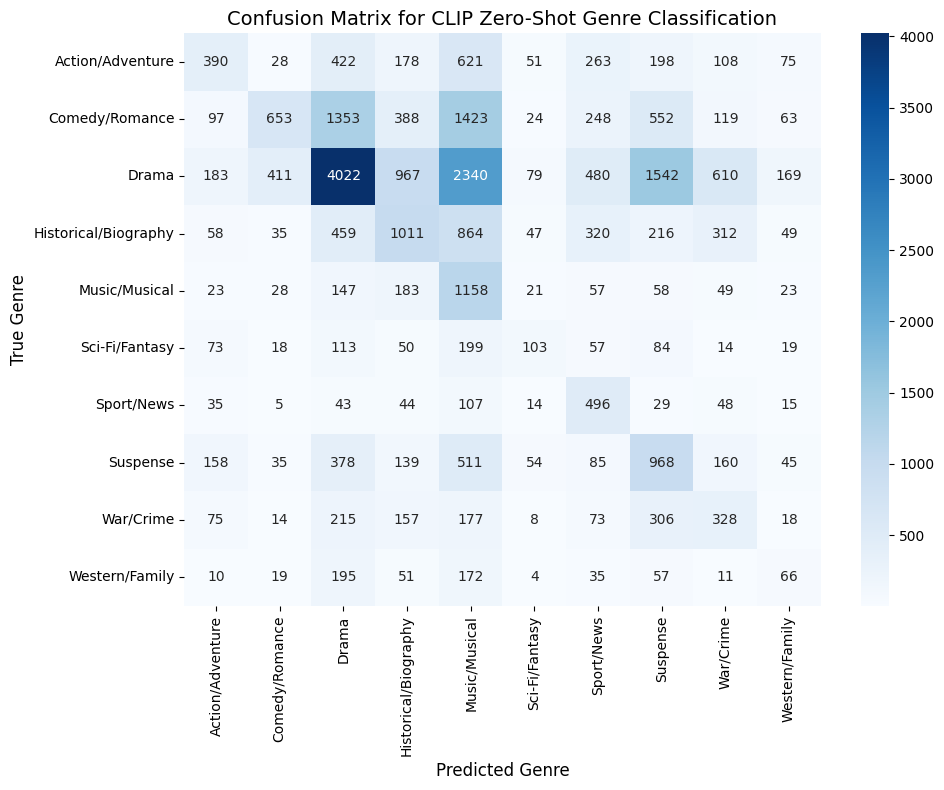

In [67]:

# Plot the confusion matrix for better visualization.
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_genres, yticklabels=unique_genres)
plt.xlabel("Predicted Genre", fontsize=12)
plt.ylabel("True Genre", fontsize=12)
plt.title("Confusion Matrix for CLIP Zero-Shot Genre Classification", fontsize=14)
plt.tight_layout()
plt.show()

In [68]:
accuracy_CLIP = accuracy_score(true_labels, predicted_labels)
print("Accuracy Score: {:.2%}".format(accuracy_CLIP))

Accuracy Score: 31.42%


**CNN (Resnet 50) with Dense Layer**

In [60]:
# Set a random seed for reproducibility.
tf.random.set_seed(42)
np.random.seed(42)

# Define target size for the network (width, height)
TARGET_SIZE = (224, 224)

In [62]:
# Step 2: Define a function to resize an image while preserving aspect ratio and pad it to the target size.
def resize_with_padding(image, target_size):
    """
    Resize a PIL Image while keeping its aspect ratio and pad it to the target size.
    
    Parameters:
        image (PIL.Image): The input image.
        target_size (tuple): Desired (width, height) output size.
        
    Returns:
        new_image (PIL.Image): Image resized and padded to the target size.
    """
    target_width, target_height = target_size
    original_width, original_height = image.size
    
    # Calculate scale factor while preserving aspect ratio.
    scale = min(target_width / original_width, target_height / original_height)
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)
    
    # Use Image.Resampling.LANCZOS for high-quality downsampling.
    resized_image = image.resize((new_width, new_height), resample=Image.Resampling.LANCZOS)
    
    # Create a new image with a black background and paste the resized image centered.
    new_image = Image.new("RGB", (target_width, target_height))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))
    
    return new_image

In [64]:
# Step 3: Define a function to load and preprocess an image from disk.
def load_and_preprocess_image(tconst, target_size=TARGET_SIZE):
    """
    Load an image from a given tconst (movie id), resize it using padding,
    and convert it to an array.
    
    Parameters:
        tconst (str): IMDb identifier of the movie (used for filename).
        target_size (tuple): Desired image output size as (width, height).
    
    Returns:
        img_array (numpy.ndarray): Processed image array.
    """
    images_dir = os.path.join("Data", "WithText")
    image_path = os.path.join(images_dir, f"{tconst}.jpg")
    if not os.path.exists(image_path):
        return None
    # Open the image using PIL.
    image = Image.open(image_path).convert("RGB")
    # Resize with padding.
    image = resize_with_padding(image, target_size)
    # Convert to array.
    img_array = img_to_array(image)
    # Optionally, you could scale pixel values here (e.g., divide by 255.0) but we let the model's preprocess layer do that.
    return img_array

In [66]:
# Step 4: Load the CSV with movie data and build labels.
df = pd.read_csv("movie_df_clean.csv")
# We use the 'reduced_genre' column as the label.
unique_genres = sorted(df['reduced_genre'].unique())
genre_to_index = {genre: i for i, genre in enumerate(unique_genres)}
df['label'] = df['reduced_genre'].map(genre_to_index)

In [68]:
# Step 5: Load images and their labels.
image_list = []
label_list = []
tconst_list = []

for idx, row in df.iterrows():
    tconst = row['tconst']
    img_array = load_and_preprocess_image(tconst)
    if img_array is None:
        print(f"Image for {tconst} not found. Skipping...")
        continue
    image_list.append(img_array)
    label_list.append(row['label'])
    tconst_list.append(tconst)

# Convert lists to numpy arrays.
X = np.array(image_list)  # Shape: (n_samples, height, width, 3)
y = np.array(label_list)

print("Loaded images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique genres:", unique_genres)

Loaded images shape: (29265, 224, 224, 3)
Labels shape: (29265,)
Unique genres: ['Action/Adventure', 'Comedy/Romance', 'Drama', 'Historical/Biography', 'Music/Musical', 'Sci-Fi/Fantasy', 'Sport/News', 'Suspense', 'War/Crime', 'Western/Family']


In [69]:
# Step 6: Split the dataset into training and validation sets (stratified).
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Training set: (23412, 224, 224, 3) (23412,)
Validation set: (5853, 224, 224, 3) (5853,)


In [70]:
# Step 7: Build a model-building function using a ResNet50 base.
num_classes = len(unique_genres)

def build_model(dropout_rate=0.5, dense_units=256, learning_rate=1e-3, trainable_base=False):
    """
    Build a CNN model using a pre-trained ResNet50 with a custom dense classification head.
    
    Hyperparameters:
        dropout_rate (float): Rate of dropout for the dense classifier.
        dense_units (int): Number of units in the dense layer.
        learning_rate (float): Learning rate for the optimizer.
        trainable_base (bool): Whether to fine-tune the ResNet50 base.
    
    Returns:
        model (tf.keras.Model): Compiled Keras model.
    """
    # Define the input shape based on the target size.
    inputs = tf.keras.Input(shape=(TARGET_SIZE[1], TARGET_SIZE[0], 3))  # (height, width, channels)
    
    # Preprocess inputs using ResNet50 preprocessing.
    # Note: The tf.keras.applications.resnet.preprocess_input function expects input pixels in range 0-255.
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    
    # Load the ResNet50 base (exclude the top classification layer).
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=x
    )
    base_model.trainable = trainable_base  # Optionally fine-tune the base.
    
    # Global Average Pooling to convert feature maps to a single vector.
    x = layers.GlobalAveragePooling2D()(base_model.output)
    # Add a fully-connected layer (dense layer) with dropout.
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    # Final classification layer.
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    
    # Compile the model.
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [72]:
# Step 8: Wrap the model with scikeras' KerasClassifier for hyperparameter tuning.
keras_clf = KerasClassifier(
    model=build_model,
    epochs=5,            # Adjust number of epochs as needed.
    batch_size=32,
    verbose=1,
    # These parameters will be tuned:
    dropout_rate=0.5,
    dense_units=256,
    learning_rate=1e-3,
    trainable_base=False,
    random_state=42
)

# Define hyperparameter grid.
param_grid = {
    'dropout_rate': [0.3, 0.5],
    'dense_units': [256, 512],
    'learning_rate': [1e-3, 1e-4],
    'trainable_base': [False, True],
}

# Use stratified K-Fold cross-validation.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create GridSearchCV object.
grid = GridSearchCV(estimator=keras_clf, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy')


In [ ]:
# Step 9: Run hyperparameter tuning.
print("Starting hyperparameter tuning...")
grid_result = grid.fit(X_train, y_train)

print("\nBest cross-validation score: {:.4f}".format(grid_result.best_score_))
print("Best hyperparameters:", grid_result.best_params_)


Starting hyperparameter tuning...


In [ ]:
# Step 10: Evaluate the best estimator on the validation set.
val_accuracy = grid_result.score(X_val, y_val)
print("Validation accuracy: {:.2%}".format(val_accuracy))

In [ ]:
# Step 11: Save the best model.
# The best model (a scikeras wrapper) holds the Keras model in .model attribute.
best_model = grid_result.best_estimator_.model
best_model.save("best_resnet50_model.h5")
print("Best CNN (ResNet50 + Dense) model saved to 'best_resnet50_model.h5'")